In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt').read().splitlines()

In [50]:


# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [51]:
import random
random.seed(42)
random.shuffle(words)

In [52]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?
device = "mps" if torch.backends.mps.is_available() else "cpu"

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182424, 8]) torch.Size([182424])
torch.Size([22836, 8]) torch.Size([22836])
torch.Size([22886, 8]) torch.Size([22886])


In [53]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '->', itos[y.item()])

........ -> n
.......n -> y
......ny -> r
.....nyr -> e
....nyre -> e
...nyree -> .
........ -> e
.......e -> d
......ed -> i
.....edi -> e
....edie -> .
........ -> c
.......c -> o
......co -> a
.....coa -> l
....coal -> s
...coals -> o
..coalso -> n
.coalson -> .
........ -> s


In [74]:
class Linear:

    def __init__(self, fan_in, fan_out, device, bias=True):
        self.weight = torch.randn((fan_in, fan_out)).to(device) / fan_in**0.5
        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, device, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # params
        self.gamma = torch.ones(dim).to(device)
        self.beta = torch.zeros(dim).to(device)

        # running vals
        self.running_mean = torch.zeros(dim).to(device)
        self.running_var = torch.ones(dim).to(device)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3: 
                dim = (0, 1)

            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + xmean * self.momentum
                self.running_var = (1 - self.momentum) * self.running_var + xvar * self.momentum
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim, device):
        self.weight = torch.randn((num_embeddings, embedding_dim), device=device)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x 
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

torch.manual_seed(42)

n_embed = 24
n_hidden = 128

# C = torch.randn((vocab_size, n_embed)).to(device)
model = Sequential([
    Embedding(vocab_size, n_embed, device),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device), Tanh(),
    Linear(n_hidden, vocab_size, device),
])


# with torch.no_grad():
#     layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [70]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
# print(Xb.shape)
Xb

e = torch.randn(4, 8, 10)
# e.view(4, 4, 20)
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))


Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [75]:
lri, lossi, stepi = [], [], []
lr = 0.01
max_steps = 10000
batch_size = 32
ud = []

for i in range(max_steps):

    # randomly select a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()

    # sgd update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(i, loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    




0 3.351591110229492


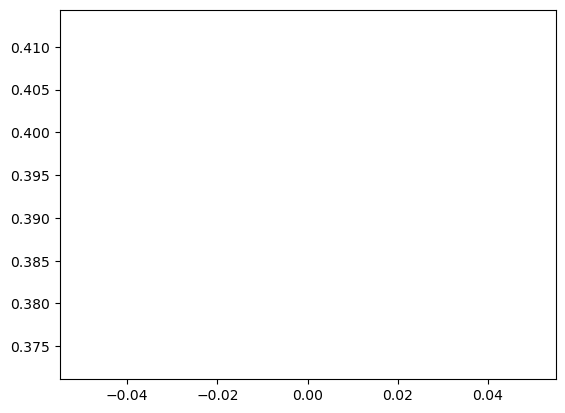

In [41]:
plt.plot(torch.tensor(lossi).view(-1, 1002).mean(1))

In [42]:
for layer in model.layers:
    layer.training = False

In [43]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.380995512008667
val 2.3786449432373047


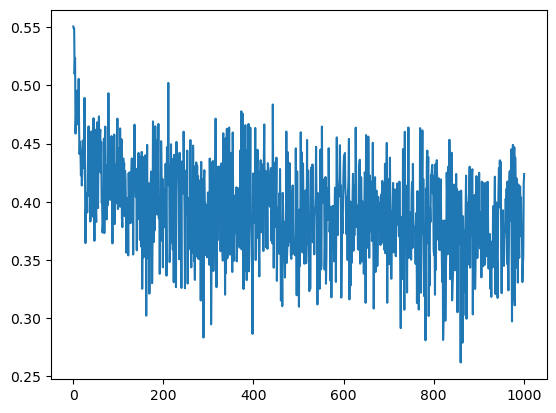

In [44]:
plt.plot(stepi, lossi)

In [45]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).to(device).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))



barineva.
gaami.
nicann.
eahiag.
zmamina.
dyese.
gamelee.
dantni.
linn.
jeile.
revia.
mirit.
haysya.
nlilynna.
eulea.
jhaca.
qimbrmh.
maralyinia.
firasazl.
kasma.
